<a href="https://colab.research.google.com/github/mernaahany/IMDB/blob/main/Imdb_lstm_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing**

In [ ]:
!pip install gensim

In [ ]:

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)


# **Import necessary libraries**


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk import ngrams
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import classification_report
import random
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')

nltk.download('wordnet')

# **Glove Setup**

In [ ]:
from gensim.models import KeyedVectors

# Load the GloVe vectors that were converted to word2vec format
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

print(f"Successfully loaded GloVe model with {len(glove_model.index_to_key)} words and {glove_model.vector_size} dimensions.")

Successfully loaded GloVe model with 400000 words and 100 dimensions.


### **Download Dataset**

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
lakshmi25npathi_imdb_dataset_of_50k_movie_reviews_path = kagglehub.dataset_download('lakshmi25npathi/imdb-dataset-of-50k-movie-reviews')

print('Data source import complete.')


Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [ ]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head(10)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
#!pip install emoji

# **EDA**

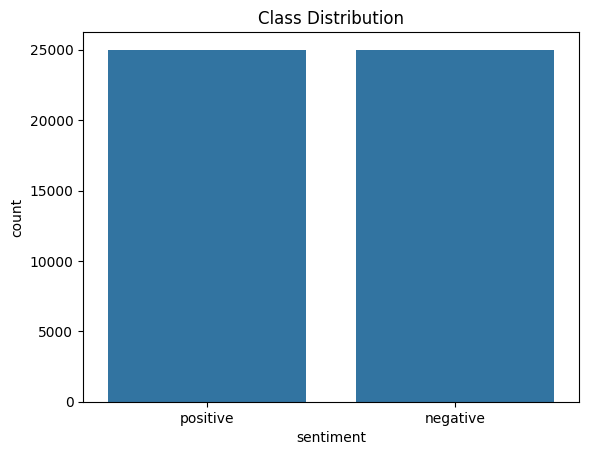

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df['sentiment'])
plt.title("Class Distribution")
plt.show()


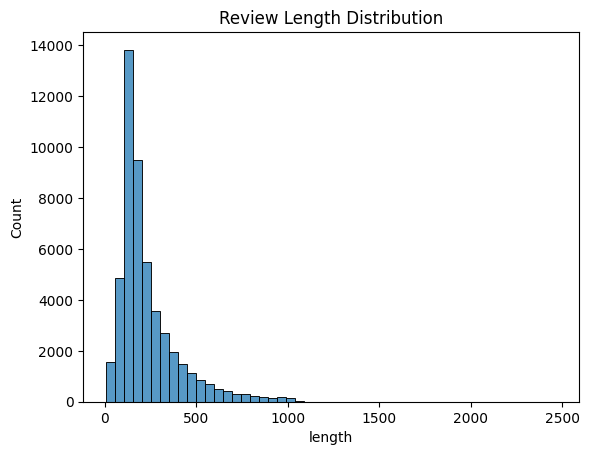

In [ ]:
df['length'] = df['review'].apply(lambda x: len(x.split()))

sns.histplot(df['length'], bins=50)
plt.title("Review Length Distribution")
plt.show()


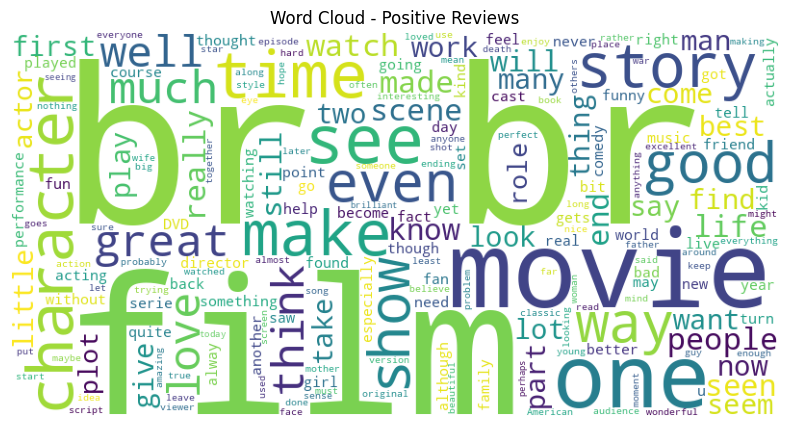

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_text = " ".join(df[df['sentiment'] == 'positive']['review'])

wc_pos = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate(positive_text)

plt.figure(figsize=(10,5))
plt.imshow(wc_pos)
plt.axis('off')
plt.title("Word Cloud - Positive Reviews")
plt.show()

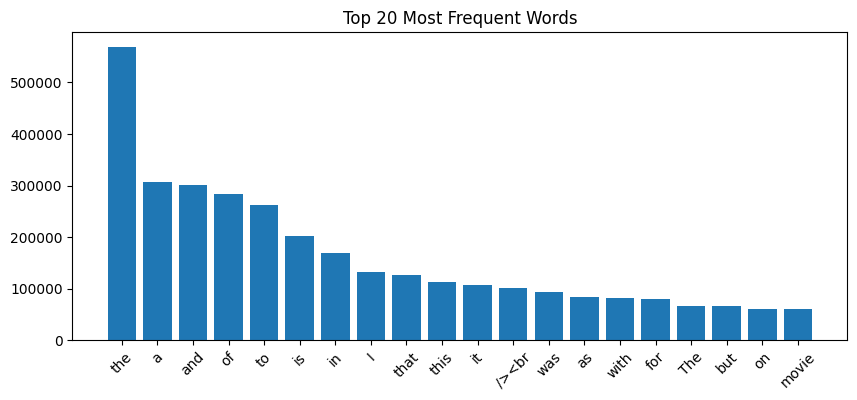

In [ ]:
from collections import Counter

all_words = " ".join(df['review']).split()
common_words = Counter(all_words).most_common(20)

words, counts = zip(*common_words)

plt.figure(figsize=(10,4))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words")
plt.show()


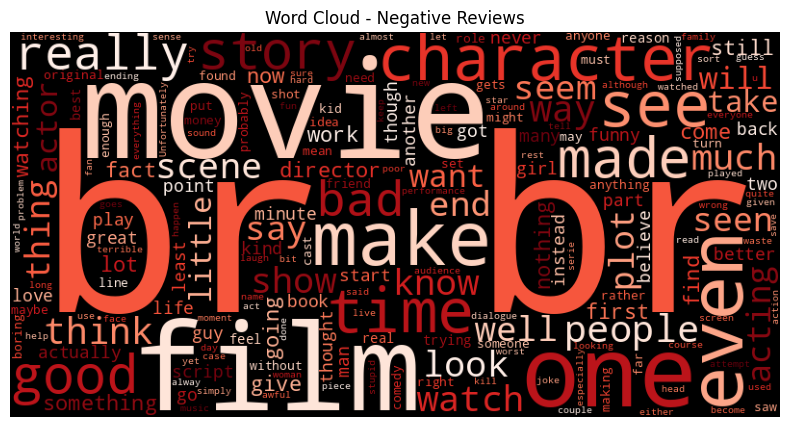

In [ ]:
negative_text = " ".join(df[df['sentiment'] == 'negative']['review'])

wc_neg = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Reds',
    max_words=200
).generate(negative_text)

plt.figure(figsize=(10,5))
plt.imshow(wc_neg)
plt.axis('off')
plt.title("Word Cloud - Negative Reviews")
plt.show()

In [ ]:
from collections import Counter

all_words = " ".join(df['review']).split()
Counter(all_words).most_common(20)

[('the', 568735),
 ('a', 306960),
 ('and', 301919),
 ('of', 283625),
 ('to', 261850),
 ('is', 203056),
 ('in', 169981),
 ('I', 132498),
 ('that', 126818),
 ('this', 113726),
 ('it', 107916),
 ('/><br', 100974),
 ('was', 92658),
 ('as', 83130),
 ('with', 82569),
 ('for', 80919),
 ('The', 67317),
 ('but', 66282),
 ('on', 61197),
 ('movie', 60762)]

# **Text Preprocessing**

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import numpy as np
#import emoji


# stopwords
stop_words = set(stopwords.words('english'))
important_words = {
    "not", "no", "never", "very", "too",
    "really", "so", "much", "more", "most"
}

stop_words = stop_words - important_words

lemmatizer = WordNetLemmatizer()

# WordNet Lemmatizer
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


contractions = {
    "shouldn't": "should not",
    "can't": "cannot",
    "won't": "will not",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'ve": " have",
    "'m": " am"
}

def expand_contractions(text):
    for contr, full in contractions.items():
        text = re.sub(r'\b' + re.escape(contr) + r'\b', full, text)
    return text


'''def convert_emojis(text):
    text = emoji.demojize(text)
    text = re.sub(r':.*?smile.*?:', ' happy_emoji ', text)
    text = re.sub(r':.*?sad.*?:|:.*?cry.*?:', ' sad_emoji ', text)
    return text'''


def handle_negation(tokens):
    negations = {"not", "no", "never"}
    new_tokens = []
    skip = False

    for i in range(len(tokens)):
        if skip:
            skip = False
            continue

        if tokens[i] in negations and i + 1 < len(tokens):
            if tokens[i+1] not in negations:
                new_tokens.append(tokens[i] + "_" + tokens[i+1])
                skip = True
            else:
                new_tokens.append(tokens[i])
        else:
            new_tokens.append(tokens[i])
    return new_tokens


def clean_text(text):
    # lowercase
    text = text.lower()

    # expand contractions
    text = expand_contractions(text)

    #text = convert_emojis(text)

    # remove urls
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)

    # remove html tags
    text = re.sub(r'<.*?>', ' ', text)

    # keep letters and apostrophe
    text = re.sub(r"[^a-zA-Z']", " ", text)

    # remove numbers
    text = re.sub(r'\d+', '', text)

    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # tokenize
    tokens = word_tokenize(text)

    # remove stopwords
    tokens = [w for w in tokens if w not in stop_words and len(w) > 1]

    # POS tagging
    tagged = pos_tag(tokens)

    # lemmatization
    final_tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in tagged
    ]

    #  handle negation
    final_tokens = handle_negation(final_tokens)

    return " ".join(final_tokens)




df["review"] = df["review"].apply(clean_text)
df["sentiment"] = df["sentiment"].map({"positive":1, "negative":0})


In [ ]:
'''x_train, x_test, y_train, y_test = train_test_split(
    df["review"], df["sentiment"], test_size=0.2, random_state=42)'''

x_train_raw, x_test_raw, y_train, y_test = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42
)


In [ ]:
vocab_size = max_words = 20000
embedding_dim =300
maxlen =300

In [ ]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df['review'])

len(tokenizer.word_index)


94241

In [ ]:
word_counts = Counter(" ".join(df['review']).split())

rare_words = [w for w,c in word_counts.items() if c < 3]
len(rare_words) / len(word_counts)


0.5581656324852416

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 20000
max_len = 300

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train_raw)

# 2) Convert to sequences
x_train_seq = tokenizer.texts_to_sequences(x_train_raw)
x_test_seq  = tokenizer.texts_to_sequences(x_test_raw)

# 3) Pad the sequences
x_train_pad = pad_sequences(x_train_seq, maxlen= maxlen, padding='post', truncating='post')
x_test_pad  = pad_sequences(x_test_seq,  maxlen= maxlen, padding='post', truncating='post')


# **Glove & Word2Vec**

In [ ]:
from gensim.models import Word2Vec


# sentences for Word2Vec training
sentences = [text.split() for text in df['review']]

w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=300,
    window=5,
    min_count=2,
    workers=4
)

embedding_dim = 300
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, index in tokenizer.word_index.items():
    if index < max_words:
        base_word = word.split('_')[0]  # remove POS
        if base_word in w2v_model.wv:
            embedding_matrix[index] = w2v_model.wv[base_word]
        else:
            embedding_matrix[index] = np.random.uniform(-0.25, 0.25, embedding_dim)



In [ ]:
embeddings_index = {}
with open('/content/glove.6B.300d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

embedding_matrix_glove = np.zeros((max_words, 300))

for word, index in tokenizer.word_index.items():
    if index < max_words:
        base_word = word.split('_')[0]  # remove POS
        vector = embeddings_index.get(base_word)
        if vector is not None:
            embedding_matrix_glove[index] = vector
        else:
            embedding_matrix_glove[index] = np.random.uniform(-0.25, 0.25, 300)


In [ ]:
missing = []
for word, index in tokenizer.word_index.items():
    if index < max_words:
        base_word = word.split('_')[0]  # POS
        if base_word not in w2v_model.wv:  # Word2Vec
            missing.append(word)

print(len(missing), "Missing embedding")


3 Missing embedding


# **LSTM - RNN - GRU**

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # x shape: (batch_size, timesteps, features)
        u_it = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a_it = tf.nn.softmax(tf.tensordot(u_it, self.u, axes=1), axis=1)
        output = tf.reduce_sum(x * a_it, axis=1)
        return output


In [ ]:

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix] ,input_length=maxlen, trainable=False))
model.add(LSTM(64, return_sequences=True))
model.add(Bidirectional(LSTM(64, return_sequences=True),input_shape=(maxlen, 300)))
model.add(Dropout(0.4))

model.add(Attention())

from tensorflow.keras.regularizers import l2

Dense(64, activation='relu', kernel_regularizer=l2(1e-8))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))


model.compile( optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_5 (Attention)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,000,000 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,000 (22.89 MB)

In [ ]:
from keras.layers import SimpleRNN

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix] ,input_length=maxlen, trainable=False))
model.add(SimpleRNN(64))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-5,
        verbose=1
    ),

    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]



In [ ]:
history_1 = model.fit(
    x_train_pad,
    y_train,
    validation_split=0.2,
    epochs=3,
    batch_size=128,
    callbacks=callbacks
)


Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8329 - loss: 0.3859
Epoch 1: val_accuracy improved from -inf to 0.82713, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 97ms/step - accuracy: 0.8330 - loss: 0.3857 - val_accuracy: 0.8271 - val_loss: 0.4342 - learning_rate: 0.0010
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8856 - loss: 0.2801
Epoch 2: val_accuracy improved from 0.82713 to 0.88412, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 93ms/step - accuracy: 0.8856 - loss: 0.2801 - val_accuracy: 0.8841 - val_loss: 0.2800 - learning_rate: 0.0010
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8985 - loss: 0.2476
Epoch 3: val_accuracy improved from 0.88412 to 0.89975, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.8985 - loss: 0.2476 - val_accuracy: 0.8997 - val_loss: 0.2453 - learning_rate: 0.0010
Restoring model weights from the end of the best 

In [ ]:
model.layers[0].trainable = True   # unfreeze

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)



In [ ]:
history_2 = model.fit(
    x_train_pad,
    y_train,
    validation_split=0.2,
    epochs=7,
    batch_size=128,
    callbacks=callbacks
)


Epoch 1/7
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9076 - loss: 0.2331
Epoch 1: val_accuracy improved from 0.89975 to 0.90625, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 102ms/step - accuracy: 0.9076 - loss: 0.2330 - val_accuracy: 0.9062 - val_loss: 0.2326 - learning_rate: 0.0010
Epoch 2/7
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9427 - loss: 0.1544
Epoch 2: val_accuracy did not improve from 0.90625
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step - accuracy: 0.9427 - loss: 0.1544 - val_accuracy: 0.9054 - val_loss: 0.2563 - learning_rate: 0.0010
Epoch 3/7
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9721 - loss: 0.0815
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 3: val_accuracy did not improve from 0.90625
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step - accuracy: 0.9721 - loss: 0.0815 - val_accuracy: 0.9011 - val_loss: 0.2810 - learning_rate: 0.0010
Epoch 4/7
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 89

In [ ]:
y_pred = (model.predict(x_test_pad) > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      4961
           1       0.90      0.92      0.91      5039

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

F1 Score: 0.9073199527744983


In [ ]:
history = model.fit(
    x_train_pad, y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.2,
    callbacks=callbacks
)


Epoch 1/10
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8278 - loss: 0.3896
Epoch 1: val_accuracy did not improve from 0.90725
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.8280 - loss: 0.3892 - val_accuracy: 0.8824 - val_loss: 0.3490 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8836 - loss: 0.2782
Epoch 2: val_accuracy did not improve from 0.90725
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.8837 - loss: 0.2782 - val_accuracy: 0.8869 - val_loss: 0.2617 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8956 - loss: 0.2519
Epoch 3: val_accuracy did not improve from 0.90725
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.8956 - loss: 0.2519 - val_accuracy: 0.8859 - val_loss: 0.2711 - learning_rate: 0.0010
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9079 - loss: 0.2251
Epoch 4: val_accuracy did not improve from 0.90725
250/250 ━━━━━━━━━━━

In [ ]:
y_pred_lstm = (model.predict(x_test_pad) > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      4961
           1       0.90      0.92      0.91      5039

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

F1 Score: 0.9073199527744983


# **ML Models**

**TF-IDF Vectorization**

In [ ]:
# TF-IDF features
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(x_train_raw)  # x_train_raw = original text column
X_test_tfidf = vectorizer.transform(x_test_raw)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report


# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

print("F1 Score (LR):", f1_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


F1 Score (LR): 0.9019953051643192
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      4961
           1       0.89      0.92      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, max_depth=20, n_jobs=-1, random_state=42)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)

print("F1 Score (RF):", f1_score(y_test, y_pred_rf))


F1 Score (RF): 0.8544061302681992


In [ ]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C=1.0, max_iter=10000)
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

print("F1 Score (SVM):", f1_score(y_test, y_pred_svm))


F1 Score (SVM): 0.9021653543307087


In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('rf', rf),
        ('svm', svm)
    ],
    voting='hard'
)
ensemble.fit(X_train_tfidf, y_train)
y_pred_ens = ensemble.predict(X_test_tfidf)
print("F1 Score (Ensemble):", f1_score(y_test, y_pred_ens))


F1 Score (Ensemble): 0.9024128162547621


In [ ]:
ml_preds = np.vstack([
    lr.predict(X_test_tfidf),
    rf.predict(X_test_tfidf),
    svm.predict(X_test_tfidf),
    y_pred_lstm.flatten()
]).T  # shape: (num_samples, 4)

# Step 2: Majority voting
from scipy.stats import mode
y_pred_ensemble = mode(ml_preds, axis=1)[0].flatten()

# ===== Evaluation =====
print("F1 Score (Ensemble):", f1_score(y_test, y_pred_ensemble))
print(classification_report(y_test, y_pred_ensemble))

F1 Score (Ensemble): 0.9056528662420382
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      4961
           1       0.91      0.90      0.91      5039

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



# **Transformers**

In [ ]:
!pip install transformers datasets torch scikit-learn


In [ ]:
from datasets import load_dataset

dataset = load_dataset("imdb")

test_data = dataset["test"]
texts = test_data["text"]
true_labels = test_data["label"]  # 0 = negative, 1 = positive


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    tokenizer="distilbert-base-uncased-finetuned-sst-2-english",
    device=0
)


Device set to use cuda:0


In [ ]:
pred_labels = []
batch_size = 32

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]

    outputs = sentiment_pipeline(
        batch_texts,
        truncation=False,
        max_length=512
    )

    for out in outputs:
        pred_labels.append(1 if out["label"] == "POSITIVE" else 0)


RuntimeError: The size of tensor a (520) must match the size of tensor b (512) at non-singleton dimension 1

In [ ]:
from datasets import Dataset

hf_dataset = Dataset.from_dict({"text": texts})


In [ ]:
texts = list(hf_dataset["text"])

texts = [t[:2000] for t in texts]


outputs = sentiment_pipeline(
    texts,
    truncation=True,
    max_length=512,
    batch_size=64
)


y_pred = [1 if o["label"] == "POSITIVE" else 0 for o in outputs]



In [ ]:
hf_dataset.features


{'text': Value('string')}

In [ ]:
from sklearn.metrics import f1_score

y_true = true_labels

print("F1 Score:", f1_score(y_true, y_pred))

F1 Score: 0.8874619247550836
